In [25]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from timeit import default_timer as timer


In [26]:
train_data_file = "Brunel_BdJPsiKs_MagU_30k.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(np.float64)

target = data.is_downstream_reconstructible
features = features.drop(features.columns[0], axis=1)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.447929,1849.101146,1083.522737,27.0,0.0,12.0,-1418.736880,-143.095899,-0.722093,-0.038671
1,0.354945,10085.622823,1345.148537,24.0,0.0,12.0,-393.699553,-284.193871,-0.129122,-0.037920
2,2.906524,2441.534682,1013.888408,24.0,0.0,12.0,-834.004914,-270.235334,-0.456235,-0.015198
3,3.234916,2604.073941,904.097232,24.0,0.0,12.0,-475.119652,-230.380918,-0.369728,-0.018967
4,0.842265,2644.554049,1068.602364,23.0,0.0,12.0,-899.187260,-101.826800,-0.440227,-0.036610


In [27]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=np.abs(data['seed_x'])
    out["abs_seed_y"]=np.abs(data['seed_y'])
    out["abs_seed_tx"]=np.abs(data['seed_tx'])
    out["abs_seed_ty"]=np.abs(data['seed_ty'])
    out['seed_r'] = np.sqrt(np.square(data.seed_x) +np.square(data.seed_y))    
    out['pseudo_rapidity'] = np.arctanh(data.seed_pt/data.seed_p)
    return out

In [28]:
features = basic_transforamtion(features)

In [29]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [30]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=12)

In [31]:
X_valid = (X_valid - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [32]:
datasets={
    "train":TensorDataset(torch.Tensor(np.array(X_train.values)).to(device), torch.Tensor(np.array(Y_train.values, dtype=np.uint8)).to(device)),
    "valid":TensorDataset(torch.Tensor(np.array(X_valid.values)).to(device), torch.Tensor(np.array(Y_valid.values, dtype=np.uint8)).to(device))
}


In [33]:
datasets["valid"].__getitem__(0)

(tensor([ 1.3830, -0.0121, -0.0142,  0.2311, -0.5876, -1.2248,  0.7084, -2.9106,
         -1.5882, -2.1764, -0.0873,  3.0382,  1.2874,  2.0683,  1.7239,  1.3785],
        device='cuda:1'), tensor(0., device='cuda:1'))

In [34]:
dataloaders = { 
    'train':DataLoader(datasets["train"], 
                   batch_size=128,
                   shuffle=True,
                    num_workers=0),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=0)
}

In [35]:
for batch in dataloaders["train"]:
    print("features", batch[0], len(batch[0]))
    print("target", batch[1], len(batch[1]))
    break

features tensor([[-1.0025, -0.0014,  0.0207,  ...,  2.4632,  1.0536, -0.3855],
        [ 0.3954, -0.0095, -0.0072,  ..., -0.6264, -0.1201, -0.1299],
        [ 0.7761, -0.0073, -0.0039,  ..., -0.2105, -0.1080, -0.4467],
        ...,
        [-0.5182, -0.0094, -0.0006,  ...,  3.1689,  0.5901,  0.2794],
        [ 0.9551, -0.0056, -0.0098,  ..., -0.6511, -0.9099, -0.8277],
        [ 0.1333, -0.0116, -0.0102,  ..., -0.5923,  0.3818,  1.1222]],
       device='cuda:1') 128
target tensor([1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
        0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 1., 1., 0.

In [36]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    process_timer = timer()
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
        
            for i, batch in enumerate(dataloaders[phase]):
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

    print("training took: ",timer()- process_timer)    
    return model, run_hist

# Build the shallow model

In [37]:
class NHiddenTrackingNetwork(torch.nn.Module):
    def __init__(self, inputs,n_hidden, hidden_dict):
        super(NHiddenTrackingNetwork, self).__init__()
        if n_hidden < 3: 
          raise ValueError("n_hidden must be greater than 2")
        self.input_layer = nn.Linear(inputs, hidden_dict[0])
        self.layers = nn.ModuleList()
        for layer_it in range(n_hidden-1):
          self.layers.append(nn.Linear(hidden_dict[layer_it],
                                       hidden_dict[layer_it+1]))
        self.output_layer = nn.Linear(hidden_dict[n_hidden-1], 2)
        self.inputs = inputs
    
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        for layer in self.layers:
          x = layer(x)
          x = F.relu(x)
        x = self.output_layer(x)
        return x

In [38]:
n_hidden = {0:40,
            1:30,
           2:20,
           3:10}

model = NHiddenTrackingNetwork(X_train.shape[1], 4, n_hidden).to(device)
model

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=16, out_features=40, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [39]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
input_layer.weight 	 torch.Size([40, 16])
input_layer.bias 	 torch.Size([40])
layers.0.weight 	 torch.Size([30, 40])
layers.0.bias 	 torch.Size([30])
layers.1.weight 	 torch.Size([20, 30])
layers.1.bias 	 torch.Size([20])
layers.2.weight 	 torch.Size([10, 20])
layers.2.bias 	 torch.Size([10])
output_layer.weight 	 torch.Size([2, 10])
output_layer.bias 	 torch.Size([2])


In [40]:
criterion = nn.CrossEntropyLoss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=50)


Epoch 1/50
----------
train loss: 0.4680, train acc: 0.7873, elapsed:144.8594
valid loss: 0.4037, valid acc: 0.8291, elapsed:15.3668

Epoch 2/50
----------
train loss: 0.3768, train acc: 0.8429, elapsed:55.7724
valid loss: 0.3554, valid acc: 0.8547, elapsed:8.0195

Epoch 3/50
----------
train loss: 0.3484, train acc: 0.8569, elapsed:56.1440
valid loss: 0.3409, valid acc: 0.8608, elapsed:7.9487

Epoch 4/50
----------
train loss: 0.3380, train acc: 0.8618, elapsed:56.0656
valid loss: 0.3332, valid acc: 0.8643, elapsed:8.0551

Epoch 5/50
----------
train loss: 0.3320, train acc: 0.8642, elapsed:55.8646
valid loss: 0.3281, valid acc: 0.8661, elapsed:8.0428

Epoch 6/50
----------
train loss: 0.3276, train acc: 0.8661, elapsed:55.9550
valid loss: 0.3244, valid acc: 0.8679, elapsed:8.1510

Epoch 7/50
----------
train loss: 0.3241, train acc: 0.8674, elapsed:55.6648
valid loss: 0.3219, valid acc: 0.8687, elapsed:8.1393

Epoch 8/50
----------
train loss: 0.3210, train acc: 0.8687, elapsed:55.8

In [48]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to(device)
    model.eval
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    fpr, tpr, thresholds = roc_curve(Y, output.cpu().detach().numpy()[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



In [49]:
torch.save(model.state_dict(), "4NN.pt")

In [50]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


In [51]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to(device)
    model.eval()
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    fpr, tpr, thresholds = roc_curve(Y, output.cpu().detach().numpy()[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



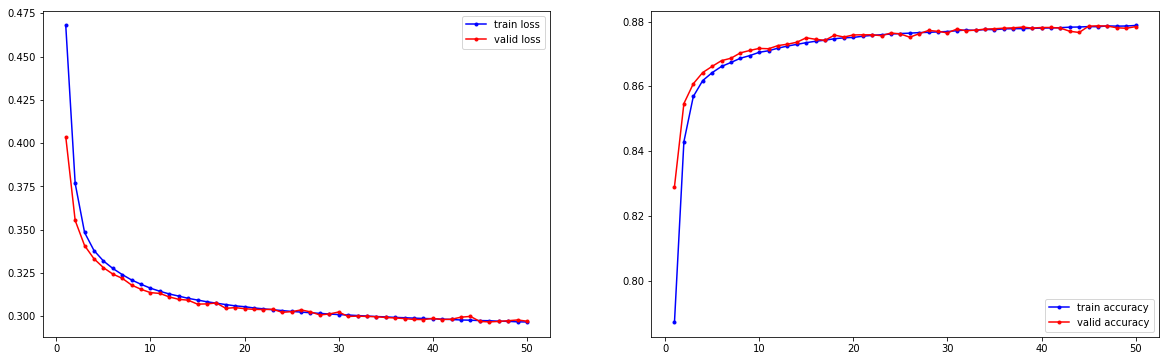

In [52]:
plot_training_classification(run_hist)

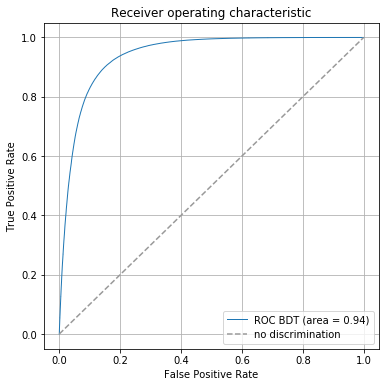

In [53]:
print_roc(model,X_valid, Y_valid )

In [54]:
for param in model.named_parameters():
  print(param)


('input_layer.weight', Parameter containing:
tensor([[-0.1016,  0.1926,  0.3010,  0.1975,  0.1279, -0.0569, -0.0336,  0.1331,
          0.0330, -0.1397, -0.0732,  0.3708, -0.0842, -0.6782,  0.2429, -0.1480],
        [-0.0294,  0.1350, -0.2153, -0.0459,  0.2422,  0.0049,  0.2345, -0.0151,
         -0.2630,  0.0542,  0.1190,  0.1118, -0.1022, -0.3697,  0.0479, -0.1541],
        [ 0.0345,  0.2852,  0.1639,  0.0073,  0.0447,  0.0897,  0.2241,  0.3617,
         -0.2418, -0.3194,  0.1722, -0.6329, -0.1643,  0.0384, -0.0470,  0.0478],
        [ 0.1008,  0.7292,  1.2251, -0.1495,  0.0220, -0.0660,  0.0011,  0.0101,
         -0.0144,  0.0004, -0.2977,  0.4401,  0.0908, -0.0460,  0.2583, -0.0573],
        [-0.0483, -1.2829, -1.1737, -0.0047,  0.0987,  0.0942, -0.2132, -0.0700,
         -0.2530,  0.0489, -0.0123,  0.0860,  0.0672,  0.1624, -0.1796,  0.0523],
        [-0.0159,  0.7847,  0.9384, -0.0700, -0.1604, -0.0359, -0.0255, -0.0103,
         -0.0711, -0.0130, -0.1412, -0.2813, -0.2658,  0.30

In [55]:
trenable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("n_params", sum([np.prod(p.size()) for p in trenable_parameters]) )

n_params 2762


In [56]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".4NN.pt")


In [57]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=50)


Epoch 1/50
----------
train loss: 0.2965, train acc: 0.8789, elapsed:174.5498
valid loss: 0.2973, valid acc: 0.8781, elapsed:25.4661

Epoch 2/50
----------
train loss: 0.2963, train acc: 0.8789, elapsed:174.9318
valid loss: 0.2963, valid acc: 0.8789, elapsed:23.7742

Epoch 3/50
----------
train loss: 0.2962, train acc: 0.8790, elapsed:56.1056
valid loss: 0.2963, valid acc: 0.8789, elapsed:8.0057

Epoch 4/50
----------
train loss: 0.2960, train acc: 0.8790, elapsed:55.9125
valid loss: 0.2958, valid acc: 0.8792, elapsed:7.8972

Epoch 5/50
----------
train loss: 0.2958, train acc: 0.8791, elapsed:55.9986
valid loss: 0.2967, valid acc: 0.8784, elapsed:7.9097

Epoch 6/50
----------
train loss: 0.2957, train acc: 0.8792, elapsed:55.7993
valid loss: 0.2959, valid acc: 0.8791, elapsed:7.9577

Epoch 7/50
----------
train loss: 0.2955, train acc: 0.8792, elapsed:56.5247
valid loss: 0.2955, valid acc: 0.8793, elapsed:7.7545

Epoch 8/50
----------
train loss: 0.2953, train acc: 0.8794, elapsed:55

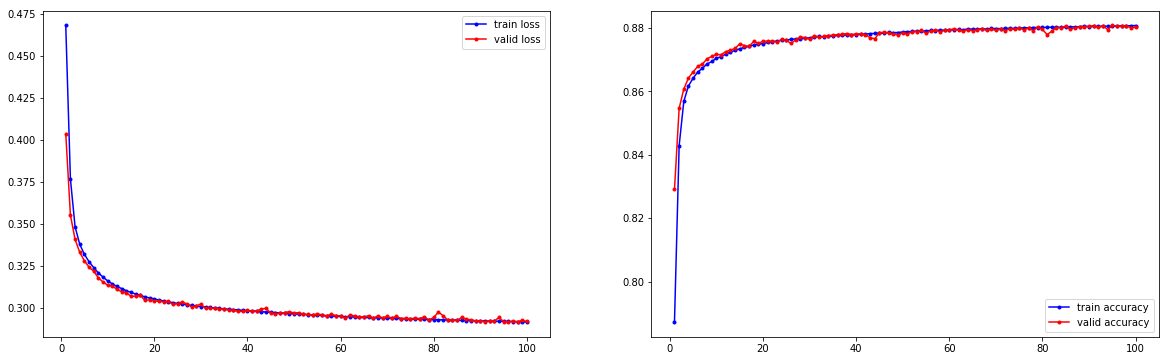

In [58]:
plot_training_classification(run_hist)

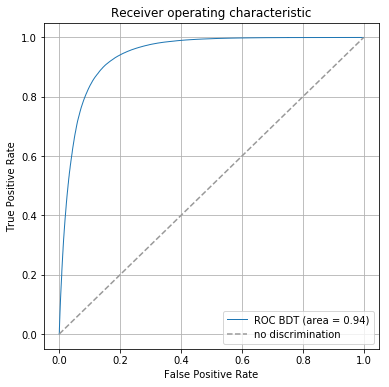

In [59]:
print_roc(model,X_valid, Y_valid )

In [60]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=50)


Epoch 1/50
----------
train loss: 0.2917, train acc: 0.8810, elapsed:173.7910
valid loss: 0.2921, valid acc: 0.8807, elapsed:25.0658

Epoch 2/50
----------
train loss: 0.2917, train acc: 0.8807, elapsed:75.5041
valid loss: 0.2912, valid acc: 0.8811, elapsed:7.8712

Epoch 3/50
----------
train loss: 0.2916, train acc: 0.8809, elapsed:55.1636
valid loss: 0.2912, valid acc: 0.8812, elapsed:8.0549

Epoch 4/50
----------
train loss: 0.2916, train acc: 0.8809, elapsed:55.9192
valid loss: 0.2918, valid acc: 0.8808, elapsed:7.8347

Epoch 5/50
----------
train loss: 0.2915, train acc: 0.8808, elapsed:55.5849
valid loss: 0.2916, valid acc: 0.8811, elapsed:7.8946

Epoch 6/50
----------
train loss: 0.2915, train acc: 0.8809, elapsed:55.1409
valid loss: 0.2932, valid acc: 0.8802, elapsed:7.8926

Epoch 7/50
----------
train loss: 0.2915, train acc: 0.8809, elapsed:55.1906
valid loss: 0.2924, valid acc: 0.8804, elapsed:7.9825

Epoch 8/50
----------
train loss: 0.2914, train acc: 0.8810, elapsed:55.2

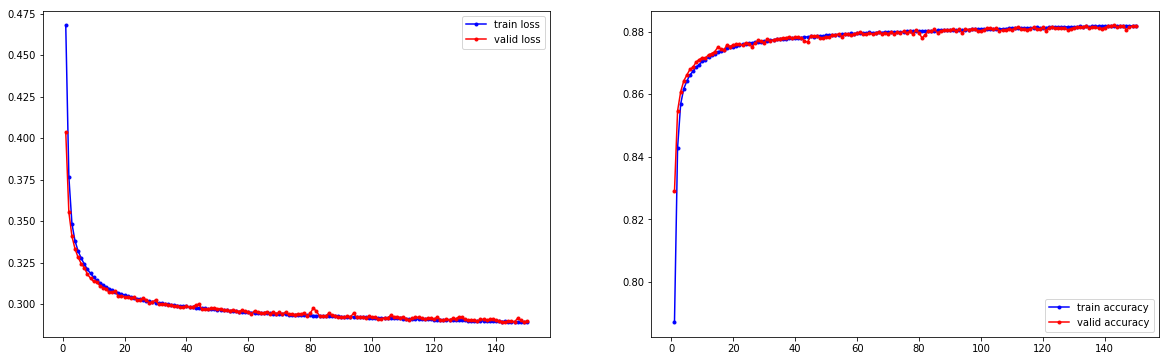

In [61]:
plot_training_classification(run_hist)

In [62]:
torch.save(model.state_dict(), "4NN_2.pt")

In [63]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=250)


Epoch 1/250
----------
train loss: 0.2892, train acc: 0.8821, elapsed:150.1393
valid loss: 0.2891, valid acc: 0.8822, elapsed:7.6174

Epoch 2/250
----------
train loss: 0.2892, train acc: 0.8819, elapsed:55.7972
valid loss: 0.2897, valid acc: 0.8816, elapsed:7.9395

Epoch 3/250
----------
train loss: 0.2894, train acc: 0.8821, elapsed:55.1996
valid loss: 0.2940, valid acc: 0.8795, elapsed:7.9227

Epoch 4/250
----------
train loss: 0.2892, train acc: 0.8820, elapsed:55.1039
valid loss: 0.2897, valid acc: 0.8817, elapsed:8.0179

Epoch 5/250
----------
train loss: 0.2891, train acc: 0.8820, elapsed:55.1841
valid loss: 0.2895, valid acc: 0.8817, elapsed:7.9851

Epoch 6/250
----------
train loss: 0.2890, train acc: 0.8821, elapsed:55.0987
valid loss: 0.2894, valid acc: 0.8817, elapsed:7.9309

Epoch 7/250
----------
train loss: 0.2891, train acc: 0.8822, elapsed:55.1913
valid loss: 0.2890, valid acc: 0.8820, elapsed:7.9437

Epoch 8/250
----------
train loss: 0.2889, train acc: 0.8820, elaps

KeyboardInterrupt: 

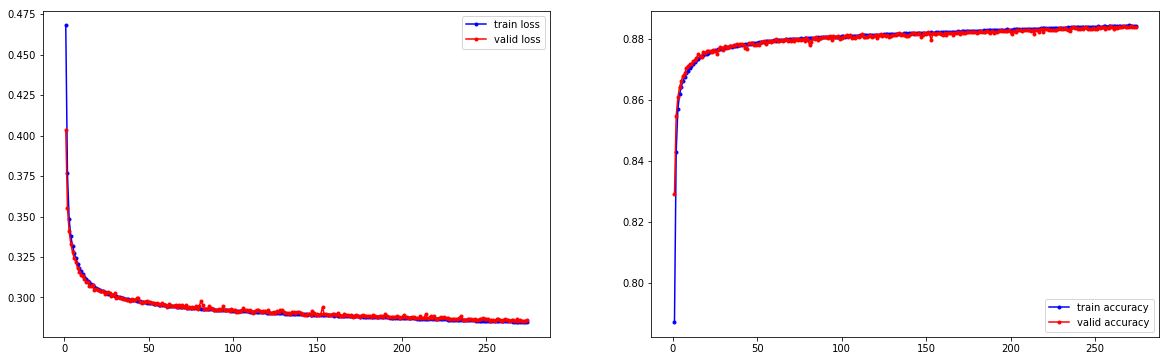

In [64]:
plot_training_classification(run_hist)

In [65]:
torch.save(model.state_dict(), "4NN_3.pt")

In [66]:
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=50)


Epoch 1/50
----------
train loss: 0.2830, train acc: 0.8852, elapsed:84.5162
valid loss: 0.2842, valid acc: 0.8847, elapsed:7.5548

Epoch 2/50
----------
train loss: 0.2828, train acc: 0.8852, elapsed:53.0870
valid loss: 0.2840, valid acc: 0.8847, elapsed:7.4328

Epoch 3/50
----------
train loss: 0.2828, train acc: 0.8853, elapsed:52.8297
valid loss: 0.2841, valid acc: 0.8846, elapsed:7.5598

Epoch 4/50
----------
train loss: 0.2828, train acc: 0.8853, elapsed:52.9253
valid loss: 0.2841, valid acc: 0.8847, elapsed:7.6781

Epoch 5/50
----------
train loss: 0.2828, train acc: 0.8854, elapsed:53.2989
valid loss: 0.2840, valid acc: 0.8847, elapsed:7.6243

Epoch 6/50
----------
train loss: 0.2827, train acc: 0.8854, elapsed:53.0664
valid loss: 0.2840, valid acc: 0.8847, elapsed:7.5469

Epoch 7/50
----------
train loss: 0.2827, train acc: 0.8853, elapsed:52.7336
valid loss: 0.2840, valid acc: 0.8847, elapsed:7.4913

Epoch 8/50
----------
train loss: 0.2827, train acc: 0.8853, elapsed:52.884

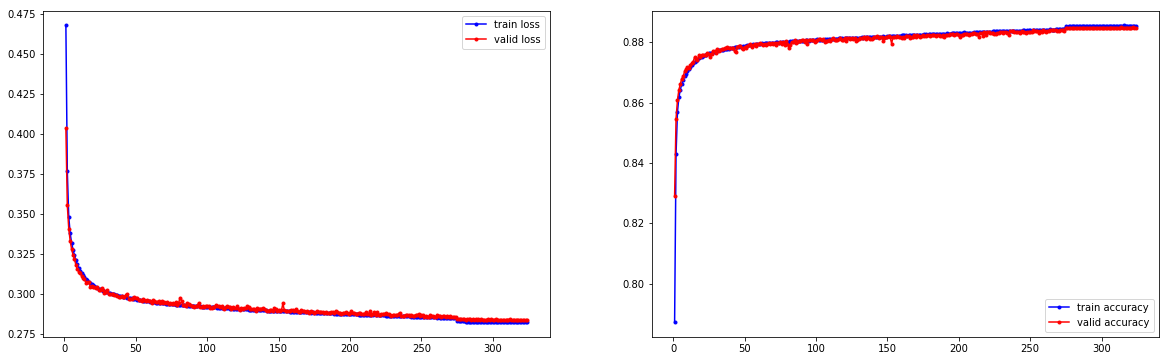

In [68]:
plot_training_classification(run_hist)